In [1]:
#Imports — run this cell first
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# modeling tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# save/load models
import joblib

# optional: live data
try:
    import yfinance as yf
except Exception:
    yf = None  # if yfinance is not installed, live step will skip

pd.set_option('display.max_columns', 80)
plt.rcParams['figure.figsize'] = (10,4)

print("Imports ready")


Imports ready


In [3]:
# Load CSV files you uploaded
history_path = "Coca-Cola_stock_history.csv"
info_path = "Coca-Cola_stock_info.csv"

# safety checks
if not os.path.exists(history_path):
    raise FileNotFoundError(f"Missing history CSV at {history_path}")
if not os.path.exists(info_path):
    raise FileNotFoundError(f"Missing info CSV at {info_path}")

# Load files
df = pd.read_csv(history_path)
df_info = pd.read_csv(info_path, header=None, names=['Description','Information'], dtype=str, na_filter=False)

# Show quick preview
print("History shape:", df.shape)
display(df.head(4))

print("\nInfo file preview:")
display(df_info.head(6))


History shape: (15311, 8)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1962-01-02,0.050016,0.051378,0.050016,0.050016,806400,0.0,0
1,1962-01-03,0.049273,0.049273,0.048159,0.048902,1574400,0.0,0
2,1962-01-04,0.049026,0.049645,0.049026,0.049273,844800,0.0,0
3,1962-01-05,0.049273,0.049892,0.048035,0.048159,1420800,0.0,0



Info file preview:


,Description,Information
0,Key,Value
1,zip,30313
2,sector,Consumer Defensive
3,fullTimeEmployees,80300
4,longBusinessSummary,"The Coca-Cola Company, a beverage company, man..."
5,city,Atlanta


In [4]:
# Normalize Date and quick check
df['Date'] = pd.to_datetime(df['Date'].astype(str), errors='coerce')

# Sort by date and reset index
df = df.sort_values('Date').reset_index(drop=True)

print("Columns:", df.columns.tolist())
print("\nDtypes:\n", df.dtypes)
print("\nMissing counts (top):\n", df.isnull().sum().sort_values(ascending=False).head(20))


Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']

Dtypes:
 Date            datetime64[ns]
Open                   float64
High                   float64
Low                    float64
Close                  float64
Volume                   int64
Dividends              float64
Stock Splits             int64
dtype: object

Missing counts (top):
 Date            8840
Open               0
High               0
Low                0
Close              0
Volume             0
Dividends          0
Stock Splits       0
dtype: int64


In [6]:
# Clean numeric columns
numeric_cols = ['Open','High','Low','Close','Volume','Dividends','Stock Splits']

for c in numeric_cols:
    if c in df.columns:
        df[c] = df[c].astype(str).str.replace(r'[\$,]', '', regex=True)
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Modern fill methods (no warnings)
df.ffill(inplace=True)
df.bfill(inplace=True)

# Fill remaining numeric gaps
for c in numeric_cols:
    if c in df.columns:
        df[c] = df[c].fillna(0)

print("Clean complete. Any remaining nulls:")
print(df.isnull().sum().loc[lambda s: s>0])


Clean complete. Any remaining nulls:
Series([], dtype: int64)


In [8]:
# create features that help the model learn trends
# Explain: MA_20 and MA_50 are simple moving averages; returns and volatility show movement

df['MA_20'] = df['Close'].rolling(window=20, min_periods=1).mean()
df['MA_50'] = df['Close'].rolling(window=50, min_periods=1).mean()
df['Daily_Return'] = df['Close'].pct_change().fillna(0)
df['Volatility_20'] = df['Daily_Return'].rolling(window=20, min_periods=1).std().fillna(0)

# simple time features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek

display(df[['Date','Close','MA_20','MA_50','Daily_Return','Volatility_20']].head(6))


,Date,Close,MA_20,MA_50,Daily_Return,Volatility_20
0,1962-01-02,0.050016,0.050016,0.050016,0.000000,0.000000
1,1962-01-03,0.048902,0.049459,0.049459,-0.022280,0.015754
2,1962-01-04,0.049273,0.049397,0.049397,0.007598,0.015529
3,1962-01-05,0.048159,0.049087,0.049087,-0.022616,0.015468
4,1962-01-08,0.047664,0.048803,0.048803,-0.010282,0.013403
5,1962-01-09,0.048530,0.048757,0.048757,0.018181,0.016479


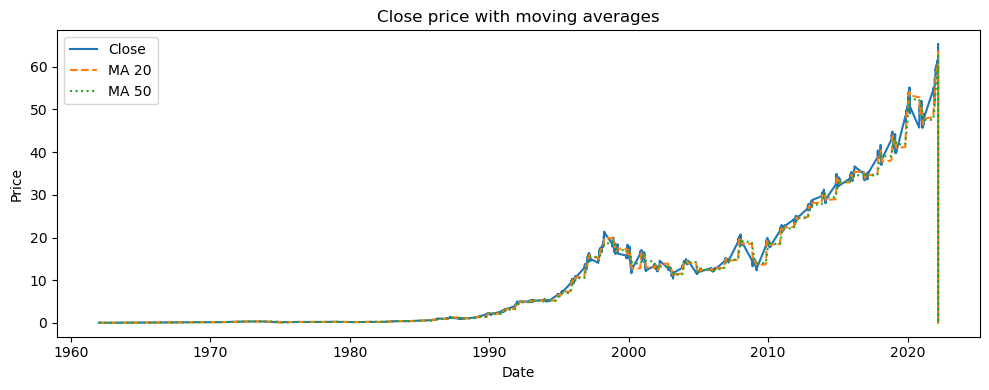

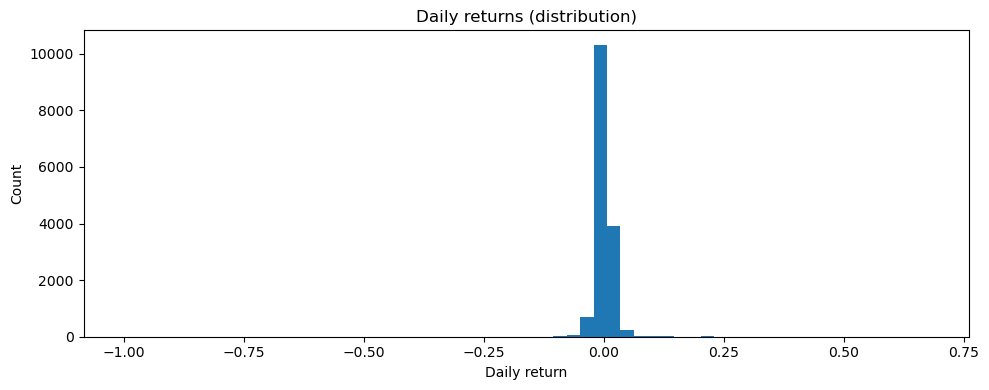

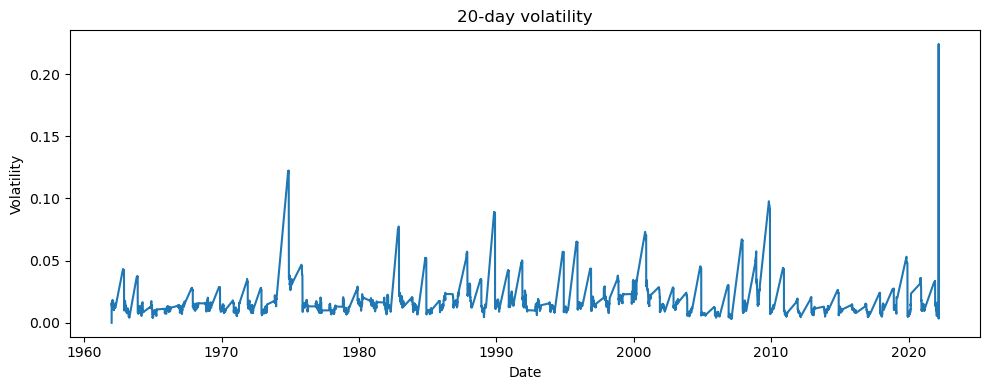

In [9]:
# quick charts to visually check the data
# Simple: price with MAs, returns histogram, volatility line

plt.figure()
plt.plot(df['Date'], df['Close'], label='Close')
plt.plot(df['Date'], df['MA_20'], label='MA 20', linestyle='--')
plt.plot(df['Date'], df['MA_50'], label='MA 50', linestyle=':')
plt.title('Close price with moving averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(df['Daily_Return'].dropna(), bins=60)
plt.title('Daily returns (distribution)')
plt.xlabel('Daily return')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(df['Date'], df['Volatility_20'])
plt.title('20-day volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.tight_layout()
plt.show()


In [10]:
# prepare features and split in time order (no shuffling)
candidate = ['Open','High','Low','Volume','MA_20','MA_50','Daily_Return','Volatility_20','Year','Month','DayOfWeek']
features = [c for c in candidate if c in df.columns]
target = 'Close'

X = df[features].copy()
y = df[target].copy()

split_index = int(len(df) * 0.8)
X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

print("Train rows:", X_train.shape[0], "Test rows:", X_test.shape[0])
print("Features used:", features)


Train rows: 12248 Test rows: 3063
Features used: ['Open', 'High', 'Low', 'Volume', 'MA_20', 'MA_50', 'Daily_Return', 'Volatility_20', 'Year', 'Month', 'DayOfWeek']


In [11]:
# scale numeric columns to help learning
num_to_scale = X_train.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[num_to_scale] = scaler.fit_transform(X_train[num_to_scale])
X_test_scaled[num_to_scale]  = scaler.transform(X_test[num_to_scale])

print("Scaled columns:", num_to_scale)


Scaled columns: ['Open', 'High', 'Low', 'Volume', 'MA_20', 'MA_50', 'Daily_Return', 'Volatility_20', 'Year', 'Month', 'DayOfWeek']


In [12]:
# train a simple baseline (linear) and a stronger model (random forest)
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)

# fit
lr.fit(X_train_scaled, y_train)
rf.fit(X_train_scaled, y_train)

# predict
pred_lr = lr.predict(X_test_scaled)
pred_rf = rf.predict(X_test_scaled)

# simple metrics helper
def show_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    print(f"{name}: MSE={mse:.3f}, MAE={mae:.3f}, R2={r2:.3f}")

show_metrics(y_test, pred_lr, "Linear Regression")
show_metrics(y_test, pred_rf, "Random Forest")


Linear Regression: MSE=0.022, MAE=0.094, R2=1.000
Random Forest: MSE=0.203, MAE=0.192, R2=0.999


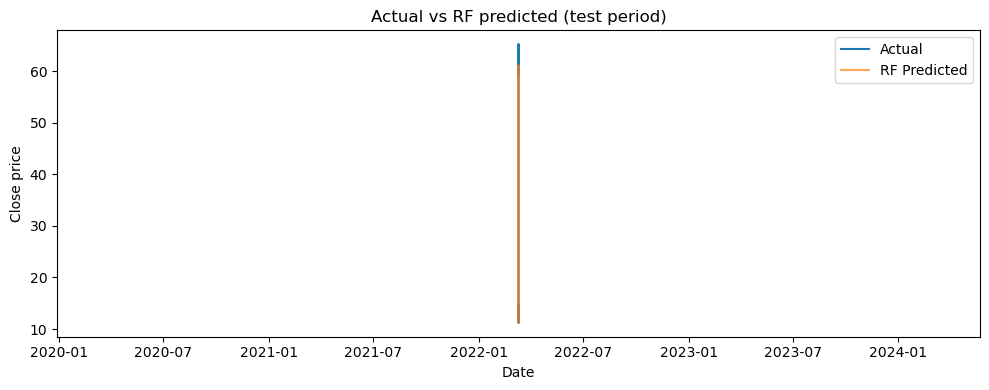

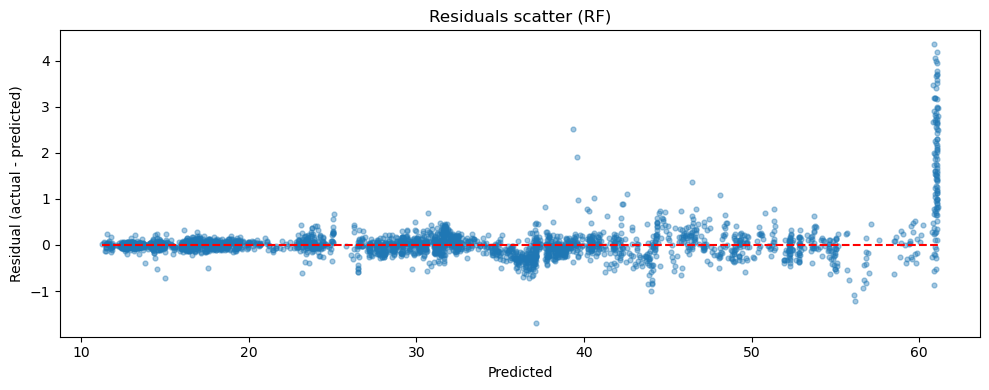

In [13]:
# see how predictions match actuals and check residuals
plt.figure()
plt.plot(df['Date'].iloc[split_index:], y_test.values, label='Actual')
plt.plot(df['Date'].iloc[split_index:], pred_rf, label='RF Predicted', alpha=0.7)
plt.title('Actual vs RF predicted (test period)')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend()
plt.tight_layout()
plt.show()

resids = y_test.values - pred_rf
plt.figure()
plt.scatter(pred_rf, resids, s=12, alpha=0.4)
plt.hlines(0, xmin=min(pred_rf), xmax=max(pred_rf), colors='red', linestyles='dashed')
plt.xlabel('Predicted')
plt.ylabel('Residual (actual - predicted)')
plt.title('Residuals scatter (RF)')
plt.tight_layout()
plt.show()
